# Proyecto Integrador

Diseñar e implementar un modelo predictivo con aprendizaje supervisado para problemas de regresión polinomial multivariada (Usar los datos Engine behavior, Concrete Compressive Strength y Gas Turbine Emission) y clasificación polinomial multivariada (Usar los datos Microchips, Breast cancer y Dermatology), que incluya mas de un algoritmo de entrenamiento asignado por equipo (SGD, GDX, Rprop, RMSprop, RAdam, Adamax, Adam, Adadelta, AdamW, Adagrad, ...); técnicas de regularización (L1, L2, ...); parada temprana de entrenamiento; pre-procesamiento de datos (normalización, selección de tasas de entrenamiento, validación y prueba); formas de aprendizaje (online, batch y minibatch); métricas de desempeño (regresión: SSE, MSE, RMSE y R2; clasificación: matriz de confusion, ROC, Entropia cruzada binaria y entropia cruzada categorica). El proyecto deberá incluir lo siguiente:

In [1]:
from sklearn.model_selection import train_test_split
import math
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import time
from abc import ABC, abstractmethod

In [2]:
class DataProcessor:
  # Data normalization
  def normalize_data(self, X):
      return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

  # Preprocess data
  def preprocess_data(self, X, y, test_size=0.2, val_size=0.2):
      X = self.normalize_data(X)
      y = self.normalize_data(y)
      X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size)
      val_size_adjusted = val_size / (1 - test_size)
      X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size_adjusted)
      return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
class Metrics:
  # Mean Absolute Error (MAE)
  def __mean_absolute_error(self, y_true, y_pred):
      return np.mean(np.abs(y_true - y_pred))

  # Mean Squared Error (MSE)
  def __mean_squared_error(self, y_true, y_pred):
      return np.mean((y_true - y_pred) ** 2)

  # Root Mean Squared Error (RMSE)
  def __root_mean_squared_error(self, y_true, y_pred):
      return np.sqrt(self.__mean_squared_error(y_true, y_pred))

  # R-squared (R^2) Score
  def __r2_score(self, y_true, y_pred):
      numerator = np.sum((y_true - y_pred) ** 2, axis = 0)
      denominator = np.sum((y_true - np.mean(y_true, axis=0)) ** 2, axis = 0)
      r2 = 1 - (numerator / denominator)

      overall_r2 = np.mean(r2)
      return overall_r2

  def printErrors(self, Y, Yh):
    # Mean Absolute Error (MAE)
    mae = self.__mean_absolute_error(Y, Yh)
    print("Mean Absolute Error (MAE):", mae)

    # Mean Squared Error (MSE)
    mse = self.__mean_squared_error(Y, Yh)
    print("Mean Squared Error (MSE):", mse)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    # R-squared (R^2) Score
    r2 = self.__r2_score(Y, Yh)
    print("R-squared (R^2) Score:", r2)

# General Trainer

In [4]:
class Trainer(ABC):
  def __init__(self, X, Y, degree=1, test_size=0.2 , val_size=0.2, validation=True, tolerance=5):
    self.dataProcessor = DataProcessor()

    self.degree = degree
    self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = self.dataProcessor.preprocess_data(X, Y, test_size=test_size, val_size=val_size)
    if(len(self.y_train.shape) == 1):
      self.y_train = np.reshape(self.y_train, (len(self.y_train), 1), order='C')
      self.y_test = np.reshape(self.y_test, (len(self.y_test), 1), order='C')
      self.y_val = np.reshape(self.y_val, (len(self.y_val), 1), order='C')

    self.Yh_train = 0
    self.Yh_val = 0
    self.Yh_test = 0

    self.A_train = self.designMatrix(self.X_train, self.degree)
    self.A_val = self.designMatrix(self.X_val, self.degree)
    self.A_test = self.designMatrix(self.X_test, self.degree)

    self.validation = validation
    self.tolerance = tolerance

    self.rho = self.params(self.degree, self.X_train, self.y_train)
    if len(self.y_train.shape) == 1:
      m = 1

    else:
      _, m = self.y_train.shape

    self.sigma = np.eye(m)
    self.theta = np.random.rand(self.rho, m)

    self.metrics = Metrics()

  def params(self, degree, X, Y):
    _, n = X.shape
    #_, m = Y.shape

    num_params = 0

    for l in range(degree + 1):
      num_params = num_params + math.factorial(l+n-1) / (math.factorial(n-1)*math.factorial(l))
    return int(num_params)

  def powerMatrix(self, V, degree):
    if len(V) == 0 or degree == 0:
      M = 1
    else:
      M = np.array([])
      Z = V[:-1] # Get all values but the last one
      W = V[-1] # Get last value from vector

      for k in range(degree + 1):
        M = np.append(M, self.powerMatrix(Z, degree-k) * (W**k))

    return M

  def designMatrix(self, X, degree):
    q, _ = X.shape

    for p in range(q):
      a = self.powerMatrix(X[p, :], degree)

      if p == 0:
        A = a
      else:
        A = np.vstack((A, a))

    return A

  def rebuildParams(self, params, theta):
      rho, m = theta.shape

      # Reconstruction of the matrices
      theta_vector = params[0:rho*m]
      sigma_vector = params[rho*m:]

      theta_rows = rho
      theta_columns = m

      sigma_rows = m
      sigma_columns = m

      # Reconstruir la matriz desde el vector
      theta_rebuilt = theta_vector.reshape(theta_rows, theta_columns, order='C')
      sigma_rebuilt = sigma_vector.reshape(sigma_rows, sigma_columns, order='C')

      return theta_rebuilt, sigma_rebuilt

  def test(self):
    self.Yh_test = self.A_test @ self.theta
    return self.Yh_test

  def scatter(self):
    plt.figure(figsize=(10, 6))
    # Scatter plot of true values vs predicted values
    plt.scatter(self.y_test, self.Yh_test, color='blue', label='True vs Predicted')

    # Plotting the line (prediction)
    plt.plot(self.y_test, self.Yh_test, color='red', linestyle='--', label='Perfect prediction')

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

  def histogram(self):
    E = self.y_test - self.Yh_test
    _, outputs = E.shape

    for i in range(outputs):
      # Crear el histograma
      sns.histplot(E[:, i], bins=30, kde=True)
      plt.title(f'Histograma para salida {i}')
      plt.xlabel('Valor')
      plt.ylabel('Frecuencia')
      plt.show()

  def qqplot(self):
    E = self.y_test - self.Yh_test
    _, outputs = E.shape

    for i in range(outputs):
      # Crear el QQ Plot
      sm.qqplot(E[:, i], line ='45')
      plt.title(f'QQ Plot para salida {i}')
      plt.show()

  @abstractmethod
  def train():
    pass

  def plot(self, metrics=True):
    if metrics:
      self.metrics.printErrors(self.y_test, self.Yh_test)

    self.scatter()
    self.histogram()
    self.qqplot()


# Adagrad

In [5]:
class Adagrad(Trainer):
  def __init__(self,  X, Y, degree=1, test_size=0.2 , val_size=0.2, validation=True, tolerance=5):
    super().__init__(X, Y, degree, test_size, val_size, validation, tolerance)

  def objfcn(self, E, lambda_):
    q, m = E.shape
    # log (minimize sigma)
    # term_1 = -q*m/2 * np.log(2*np.pi)
    # term_2 = -q/2 * np.log(np.linalg.det(sigma))
    # term_3 = -1/2 * np.trace(E @ np.linalg.inv(sigma) @ E.T)

    # -log (maximize sigma)
    term_1 = q*m/2 * np.log(2*np.pi)
    term_2 = q/2 * np.log(np.linalg.det(self.sigma))
    term_3 = 1/2 * np.trace(E @ np.linalg.inv(self.sigma) @ E.T)

    term_reg = lambda_ * (self.theta.flatten(order='C').T @ self.theta.flatten(order='C')) # Regularization term option 1
    # term_reg = lambda_ * (E.flatten().T @ E.flatten()) # Regularization term option 2

    return term_1 + term_2 + term_3 + term_reg

  def fngrad_theta(self, E, A, lambda_):
    # With Reg
    # grad = ((E @ np.linalg.inv(sigma)).T @ A).T + 2 * lambda_ * A.T @ E # log
    grad = -((E @ np.linalg.inv(self.sigma)).T @ A).T + 2 * lambda_ * self.theta # -log option 1
    # grad = -((E @ np.linalg.inv(sigma)).T @ A).T + 2 * lambda_ * A.T @ E # -log option 2


    # Without Reg
    # grad = ((E @ np.linalg.inv(sigma)).T @ A).T # log
    # grad = -((E @ np.linalg.inv(sigma)).T @ A).T # -log

    return grad

  def fngrad_sigma(self, E):
    q, _ = E.shape
    # grad = -q/2 * np.linalg.inv(sigma) + 1/2 * np.linalg.inv(sigma) @ E.T @ E @ np.linalg.inv(sigma) # log
    grad = q/2 * np.linalg.inv(self.sigma) - 1/2 * np.linalg.inv(self.sigma) @ E.T @ E @ np.linalg.inv(self.sigma) # -log
    return grad

  def fngrad_L(self, E, A, lambda_):
    grad_theta = self.fngrad_theta(E, A, lambda_)
    grad_theta = grad_theta.flatten(order='C')

    grad_sigma = self.fngrad_sigma(E)
    grad_sigma = grad_sigma.flatten(order='C')

    return np.concatenate((grad_theta, grad_sigma))

  # AdaGrad Optimization
  def train(self, maxEpochs=100000, lr=10, lr_decay = 0, goal = 1e-8, weight_decay = 0, epsilon=1e-10, mingrad = 1e-11, lambda_=1, verbose=False, show=10000):
    stop = ""
    epochs = []
    perfs  = []
    num_fails = 0
    params = np.concatenate((self.theta.flatten(order='C'), self.sigma.flatten(order='C'))) # Vectorize the parameters matrices
    state_sum = np.zeros(params.shape)

    for epoch in range(1, maxEpochs+1):
      E = self.y_train - self.A_train @ self.theta
      q, _ = E.shape
      SSE = E.flatten(order='C').T @ E.flatten(order='C')
      MSE = SSE / q

      # Calculate the performance
      perf = self.objfcn(E, lambda_)

      # Calculate the gradient of the parameters (sigma, theta)
      gX = self.fngrad_L(E, self.A_train, lambda_)
      normgX = np.linalg.norm(gX)

      lr = lr / 1 + ((epoch-1) * lr_decay) # lr = lr when lr_decay = 0

      if weight_decay != 0:
        gX = gX + weight_decay * params

      state_sum = state_sum + gX ** 2
      params = params - lr * gX / (np.sqrt(state_sum) + epsilon)
      self.theta, self.sigma = self.rebuildParams(params, self.theta)

      E = self.y_train - self.A_train @ self.theta
      q, _ = E.shape
      SSE = E.flatten(order='C').T @ E.flatten(order='C')
      MSE = SSE / q

      if (self.validation):
        E_val = self.y_val - self.A_val @ self.theta
        q_val, _ = E_val.shape
        MSE_val = E_val.flatten(order='C') @ E_val.flatten(order='C') / q_val

        if(MSE_val > MSE):
          num_fails += 1
        else:
          num_fails = 0

      # Stopping criteria
      if epoch == maxEpochs:
        stop = "Maximum epoch reached, performance goal was not met"
      elif normgX < mingrad:
        stop = "Minimum gradient reached, performance goal was not met"
      elif num_fails >= self.tolerance:
        stop = "Maximum tolerance from validation reached"

      # Progress
      if verbose:
        if (np.fmod(epoch,show) == 0 or len(stop) != 0):
          print("AdaGrad",end = ": ")
          if np.isfinite(maxEpochs):
            print("Epoch ",epoch, "/", maxEpochs,end = " ")
          if np.isfinite(goal):
            print(", Performance of the MSE %8.3e" % MSE, "/", goal, end = " ")
          if np.isfinite(mingrad):
            print(", Gradient %8.3e" % normgX, "/", mingrad)
          print(f", Performance of the loss = {perf}")

      epochs = np.append(epochs,epoch)
      perfs = np.append(perfs,perf)

      if len(stop) != 0:
        if verbose:
          print("\nAdaGrad:",stop,"\n")
        break

    return perfs, epochs


# Levenberg-Maquardt

In [6]:
class Levenberg_Maquardt(Trainer):
  def __init__(self,  X, Y, degree=1, test_size=0.2 , val_size=0.2, validation=True, tolerance=5):
    super().__init__(X, Y, degree, test_size, val_size, validation, tolerance)

  def objfcn(self, E, theta, lambda_):
    q, _ = E.shape
    sse = (E.flatten(order='F').T @ E.flatten(order='F'))
    reg_term = lambda_ * theta.flatten(order='F').T @ theta.flatten(order='F')
    return sse + reg_term
    # return sse

  def jacobian_and_grad_fn(self, A, E, lambda_):
    q, m = E.shape
    O = np.zeros_like(A)
    Je = np.empty((0, A.shape[1]*m))
    for i in range(m):
        je = np.zeros((A.shape[0], A.shape[1]*m))
        for j in range(m):
            if i == j:
                je[:, j*A.shape[1]:(j+1)*A.shape[1]] = -A
            else:
                je[:, j*A.shape[1]:(j+1)*A.shape[1]] = O
        Je = np.vstack((Je, je))

    # Gradient
    # gradient_loss = 2.0 * Je.T @ E.flatten(order='F') # ¿? Por que el 2 afecta tanto
    gradient_loss = Je.T @ E.flatten(order='F')

    gradient = gradient_loss

    gardient_reg = 2 * lambda_ * self.theta.flatten(order='F')
    # gradient = gradient_loss + gardient_reg

    normgGrad = np.linalg.norm(gradient)

    # return Je, normgX
    return Je, gradient, normgGrad

  def rebuildTheta(self, theta_vector):
    # Reconstruir la matriz desde el vector
    return theta_vector.reshape(self.theta.shape, order='F')

  # Levenberg-Maquardt Optimization
  def train(self, lambda_=1, lr=0.01, lr_decay=0.1, lr_increment=10, lr_max=1e10,  maxEpochs=1000, mingrad=1e-11, show=1, verbose=False):
    stop = ""
    epochs = []
    perfs  = []

    vec_theta = self.theta.flatten()
    n = len(vec_theta)
    I = np.eye(n)
    num_fails = 0

    for epoch in range(1, maxEpochs+1):
      E = self.y_train - self.A_train @ self.theta

      # Calculate the performance
      perf = self.objfcn(E, self.theta, lambda_)

      # Calculate the jacobian, gradient and norm of gradient
      J, grad, normGrad = self.jacobian_and_grad_fn(self.A_train, E, lambda_)

      # Stopping criteria
      if epoch == maxEpochs:
        stop = "Maximum epoch reached, stoping"
      elif normGrad < mingrad:
        stop = "Minimum gradient reached, stoping"
      elif lr > lr_max:
        stop = "Maximum LR reached, stoping"
      elif num_fails >= self.tolerance:
        stop = "Maximum tolerance from validation reached, stoping"

      # Progress
      if verbose:
        if (np.fmod(epoch,show) == 0 or len(stop) != 0):
          print("Levenberg-Marquardt",end = ": ")
          if np.isfinite(maxEpochs):
            print("Epoch ",epoch, "/", maxEpochs,end = " ")
          if np.isfinite(mingrad):
            print(", Gradient %8.3e" % normGrad, "/", mingrad)

      epochs = np.append(epochs,epoch)
      perfs = np.append(perfs, perf)

      if len(stop) != 0:
        print("\nLevenberg-Marquardt:",stop,"\n")
        break

      while(lr <= lr_max):
        M = J.T @ J + lr * I # -> rho*m x q*m @ q*m x rho*m + rho*m x rho*m
        b = - grad # -> rho*m x q*m @ q*m x 1 = rho*m x 1
        dtheta_vec = np.linalg.inv(M) @ b # -> rho*m x rho*m @ rho*m x 1

        dtheta = self.rebuildTheta(dtheta_vec)

        new_theta = self.theta + dtheta
        self.theta = new_theta

        E = self.y_train - self.A_train @ self.theta
        perf2 = self.objfcn(E, self.theta, lambda_)

        if perf2 < perf:
          # theta = new_theta
          perf = perf2
          # print("Now best performing MSE is: ", perf_mse)
          lr *= lr_decay
          break
        lr *= lr_increment

      if (self.validation):
        E_val = self.y_val - self.A_val @ self.theta
        perf_val = self.objfcn(E_val, self.theta, lambda_)

        if(perf_val > perf):
          num_fails += 1
        else:
          num_fails = 0

    return perfs, epochs


## Engine behavior Dataset

In [7]:
engine_inputs = pd.read_csv('./data/regression/inputs_engine_dataset.csv', header=None)
engine_outputs = pd.read_csv('./data/regression/targets_engine_dataset.csv', header=None)

<ipython-input-5-5a9d66a314c7>:14: RuntimeWarning: invalid value encountered in log
  term_2 = q/2 * np.log(np.linalg.det(self.sigma))


AdaGrad: Epoch  10000 / 100000 , Performance of the MSE 1.151e-01 / 1e-08 , Gradient 1.096e+02 / 1e-11
, Performance of the loss = 3702.434410652567
AdaGrad: Epoch  20000 / 100000 , Performance of the MSE 1.158e-01 / 1e-08 , Gradient 5.694e+02 / 1e-11
, Performance of the loss = 3117.398976030714
AdaGrad: Epoch  30000 / 100000 , Performance of the MSE 1.158e-01 / 1e-08 , Gradient 1.260e+03 / 1e-11
, Performance of the loss = 2720.2295514687853
AdaGrad: Epoch  40000 / 100000 , Performance of the MSE 1.158e-01 / 1e-08 , Gradient 1.202e+03 / 1e-11
, Performance of the loss = 2396.4257250442643
AdaGrad: Epoch  50000 / 100000 , Performance of the MSE 1.158e-01 / 1e-08 , Gradient 1.661e+03 / 1e-11
, Performance of the loss = 2422.0772594088635
AdaGrad: Epoch  60000 / 100000 , Performance of the MSE 1.329e-01 / 1e-08 , Gradient 2.762e+03 / 1e-11
, Performance of the loss = 2482.111052903079
AdaGrad: Epoch  70000 / 100000 , Performance of the MSE 1.265e-01 / 1e-08 , Gradient 2.377e+03 / 1e-11


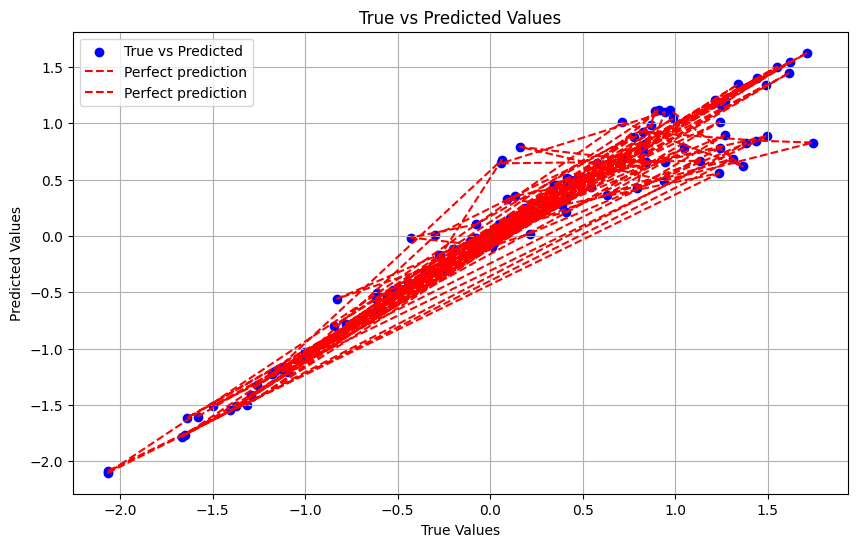

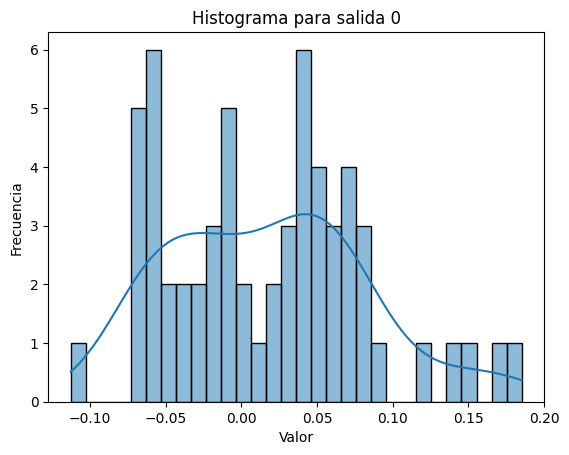

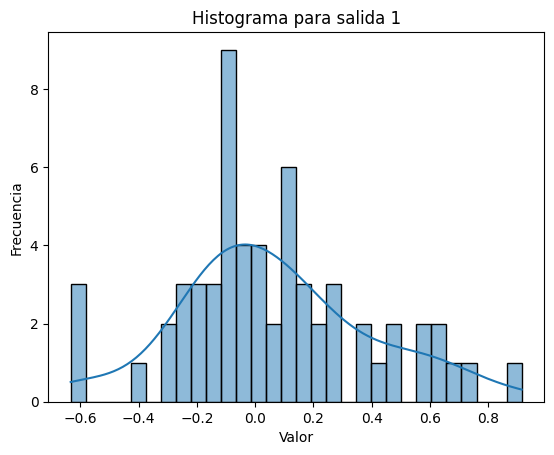

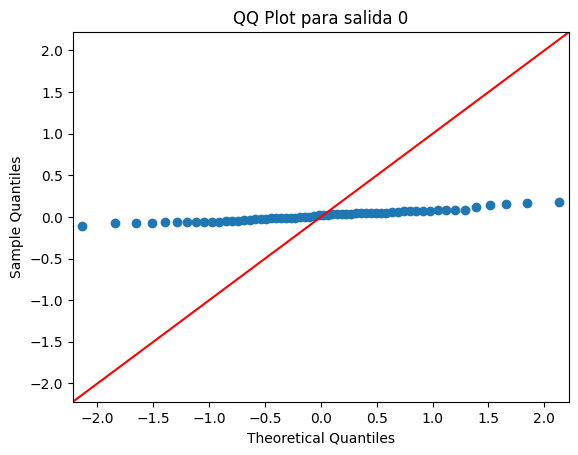

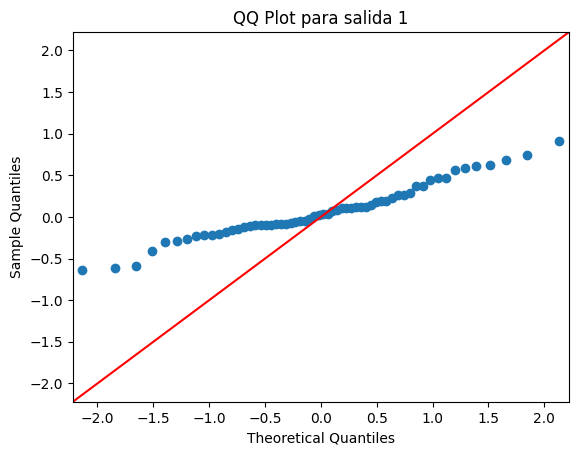

Time:  329.58193159103394


In [8]:
# Adagrad
time_old = time.time()

adagrad = Adagrad(np.array(engine_inputs), np.array(engine_outputs), degree=2, tolerance=50)
adagrad.train(verbose=True)
adagrad.test()
adagrad.plot(metrics=True)
time_new = time.time()
print("Time: ", time_new - time_old)

Levenberg-Marquardt: Epoch  1 / 1000 , Gradient 4.751e+03 / 1e-11
Levenberg-Marquardt: Epoch  2 / 1000 , Gradient 2.051e-02 / 1e-11
Levenberg-Marquardt: Epoch  3 / 1000 , Gradient 1.151e-01 / 1e-11

Levenberg-Marquardt: Maximum LR reached, stoping 

Mean Absolute Error (MAE): 0.15049065976747683
Mean Squared Error (MSE): 0.052031839231590854
Root Mean Squared Error (RMSE): 0.2281048864702176
R-squared (R^2) Score: 0.9402219630329722


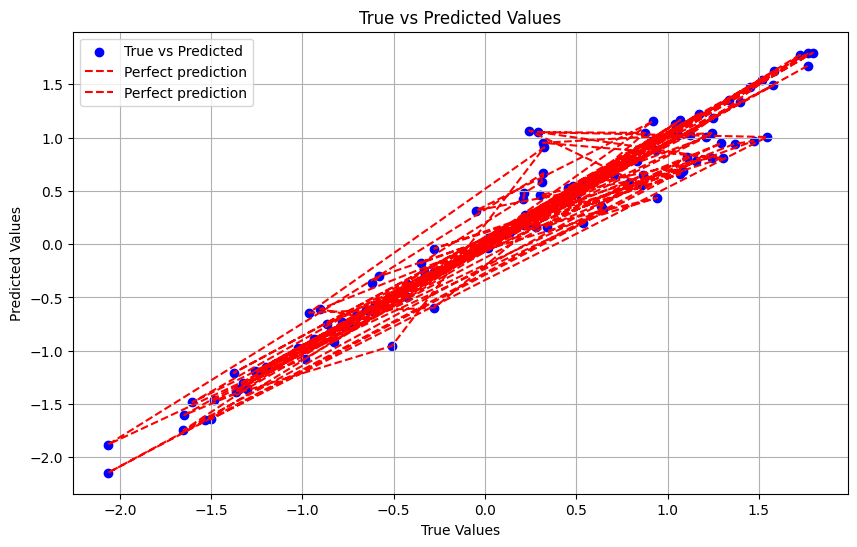

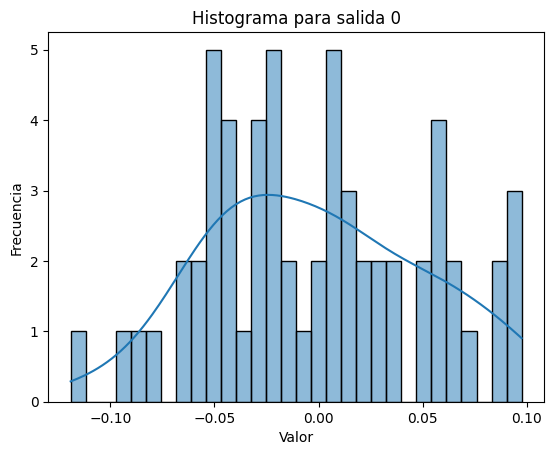

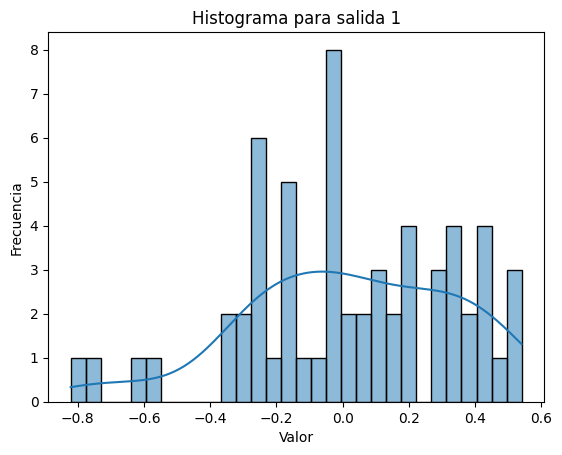

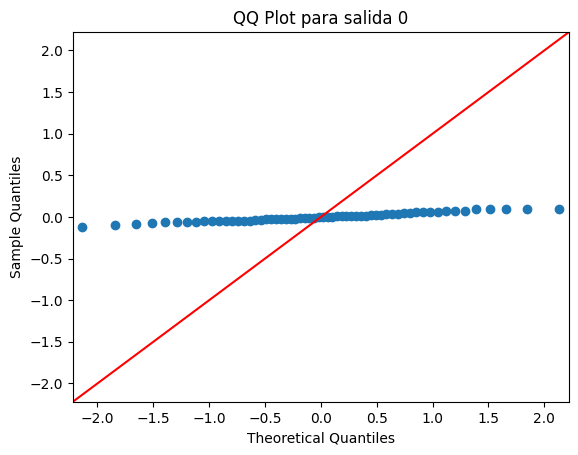

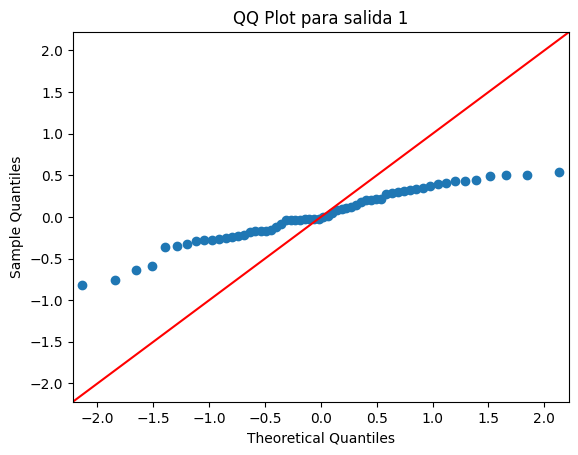

Time:  1.780419111251831


In [9]:
# Levenberg-Maquardt
time_old = time.time()

levenberg = Levenberg_Maquardt(np.array(engine_inputs), np.array(engine_outputs), degree=2, tolerance=50)
levenberg.train(verbose=True)
levenberg.test()
levenberg.plot(metrics=True)
time_new = time.time()
print("Time: ", time_new - time_old)

## Concrete Compressive Strength Dataset

In [10]:
concrete_data = pd.read_csv('./data/regression/concrete_dataset.csv', header=0)

X_concrete = concrete_data.iloc[:, 0:8]
y_concrete = concrete_data.iloc[:, 8]

AdaGrad: Epoch  100 / 100000 , Performance of the MSE 3.779e-01 / 1e-08 , Gradient 2.247e+01 / 1e-11
, Performance of the loss = 2024.2962844831945

AdaGrad: Maximum tolerance from validation reached 

Mean Absolute Error (MAE): 0.44874614453497286
Mean Squared Error (MSE): 0.3115143606690304
Root Mean Squared Error (RMSE): 0.5581347155203933
R-squared (R^2) Score: 0.6799869072351519


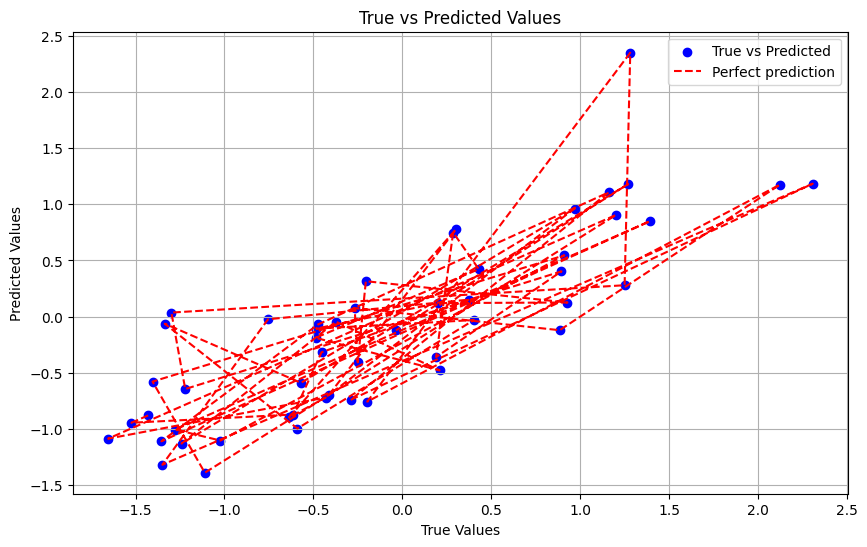

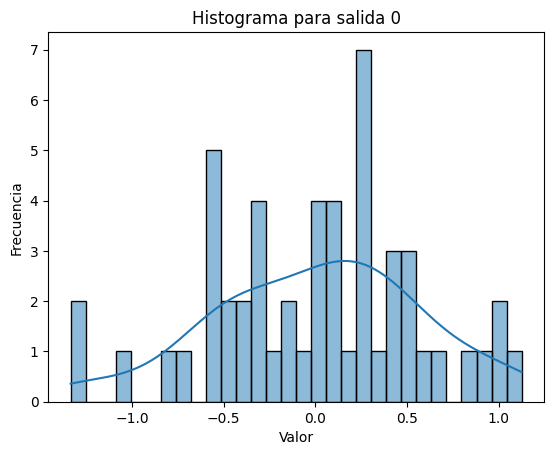

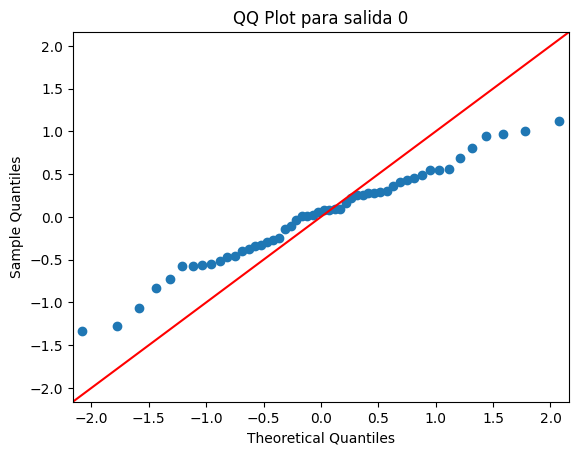

Time:  1.9134984016418457


In [11]:
# Adagrad
time_old = time.time()

adagrad = Adagrad(np.array(X_concrete), np.array(y_concrete), degree=2, tolerance=100)
adagrad.train(verbose=True)
adagrad.test()
adagrad.plot(metrics=True)
time_new = time.time()
print("Time: ", time_new - time_old)

Levenberg-Marquardt: Epoch  1 / 1000 , Gradient 6.460e+03 / 1e-11
Levenberg-Marquardt: Epoch  2 / 1000 , Gradient 4.449e-02 / 1e-11
Levenberg-Marquardt: Epoch  3 / 1000 , Gradient 1.422e-01 / 1e-11

Levenberg-Marquardt: Maximum LR reached, stoping 

Mean Absolute Error (MAE): 0.33169066147673293
Mean Squared Error (MSE): 0.21097511548809647
Root Mean Squared Error (RMSE): 0.45932027550293975
R-squared (R^2) Score: 0.8554704312222652


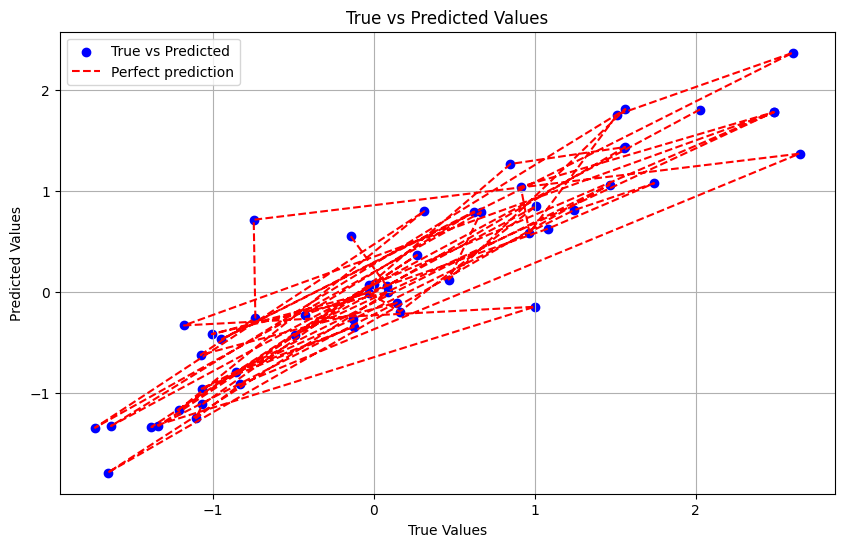

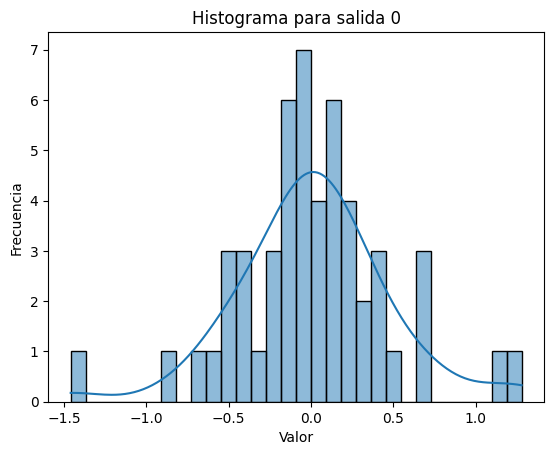

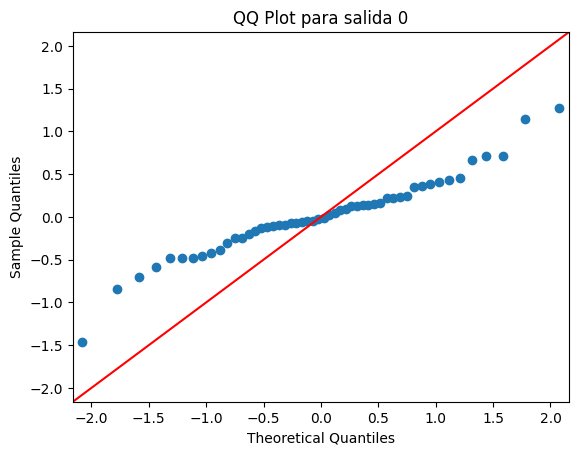

Time:  1.5357239246368408


In [12]:
# Levenber-Maquardt
time_old = time.time()

levenberg = Levenberg_Maquardt(np.array(X_concrete), np.array(y_concrete), degree=2, tolerance=100)
levenberg.train(verbose=True)
levenberg.test()
levenberg.plot(metrics=True)
time_new = time.time()
print("Time: ", time_new - time_old)

 ## Gas Turbine Emission Dataset

In [13]:
gas_turbine_data = pd.read_csv('./data/regression/gas_turbine_2015.csv', header=0)

X_gas_turbine = gas_turbine_data.iloc[:, 0:9]
y_gas_turbine = gas_turbine_data.iloc[:, 9:]

AdaGrad: Epoch  3593 / 100000 , Performance of the MSE 1.160e+00 / 1e-08 , Gradient 1.955e+02 / 1e-11
, Performance of the loss = 29539.048655671857

AdaGrad: Maximum tolerance from validation reached 

Mean Absolute Error (MAE): 0.5008949380399552
Mean Squared Error (MSE): 0.46979561983254803
Root Mean Squared Error (RMSE): 0.6854163842749516
R-squared (R^2) Score: 0.42620321481571166


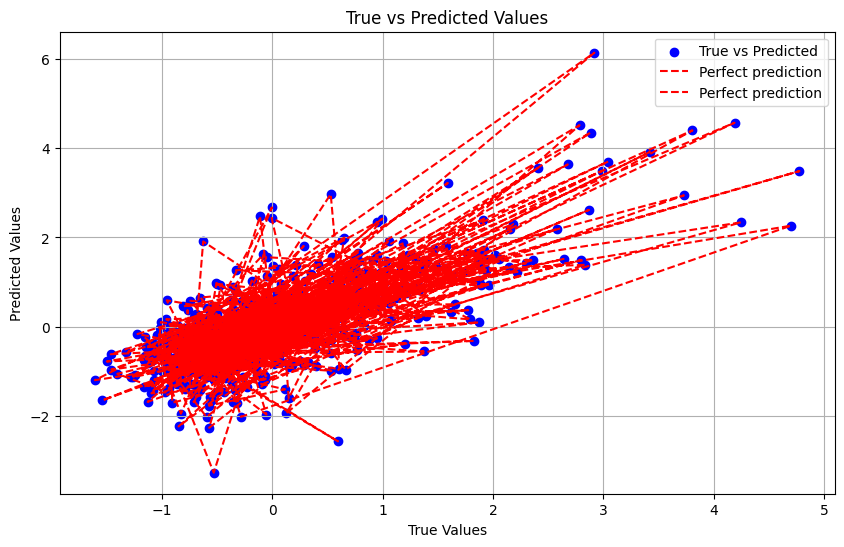

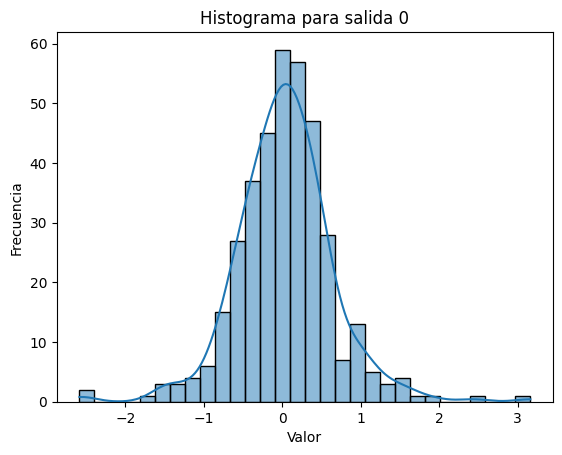

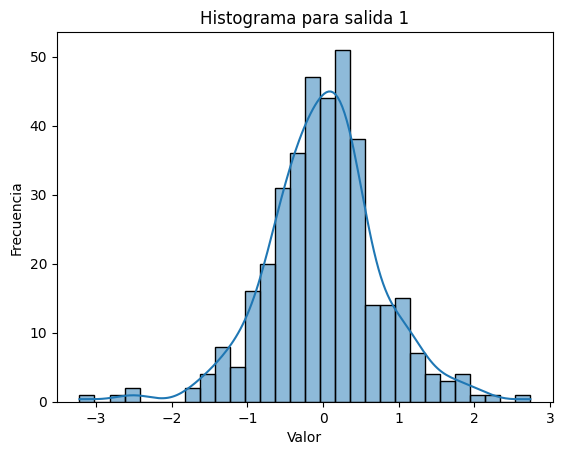

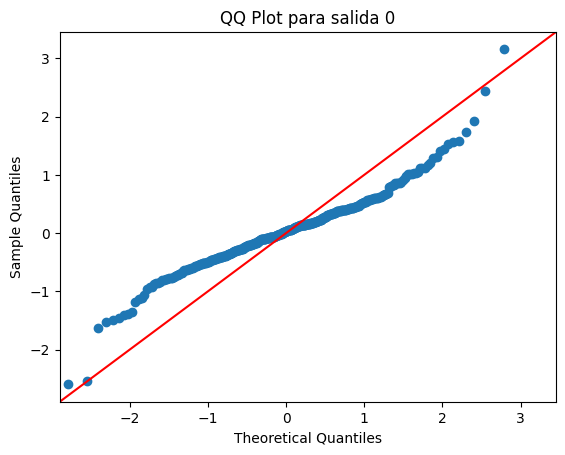

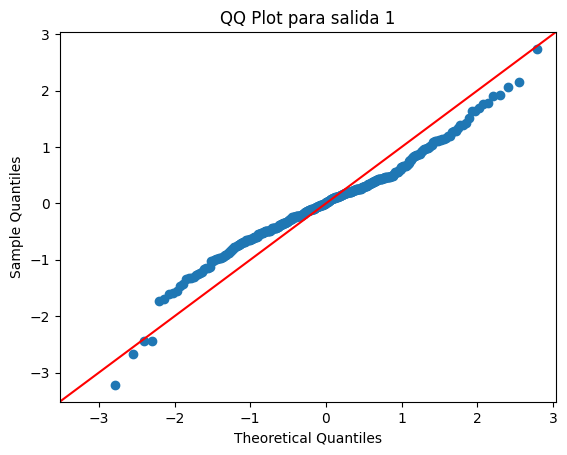

Time:  500.78939938545227


In [14]:
# Adagrad
time_old = time.time()

adagrad = Adagrad(np.array(X_gas_turbine), np.array(y_gas_turbine), degree=2, tolerance=50)
adagrad.train(verbose=True, lambda_=1)
adagrad.test()
adagrad.plot(metrics=True)
time_new = time.time()
print("Time: ", time_new - time_old)

Levenberg-Marquardt: Epoch  1 / 1000 , Gradient 4.593e+05 / 1e-11
Levenberg-Marquardt: Epoch  2 / 1000 , Gradient 1.381e-01 / 1e-11
Levenberg-Marquardt: Epoch  3 / 1000 , Gradient 4.241e-01 / 1e-11

Levenberg-Marquardt: Maximum LR reached, stoping 

Mean Absolute Error (MAE): 0.23156251146524695
Mean Squared Error (MSE): 0.11401092768135539
Root Mean Squared Error (RMSE): 0.3376550424343688
R-squared (R^2) Score: 0.8892383451639485


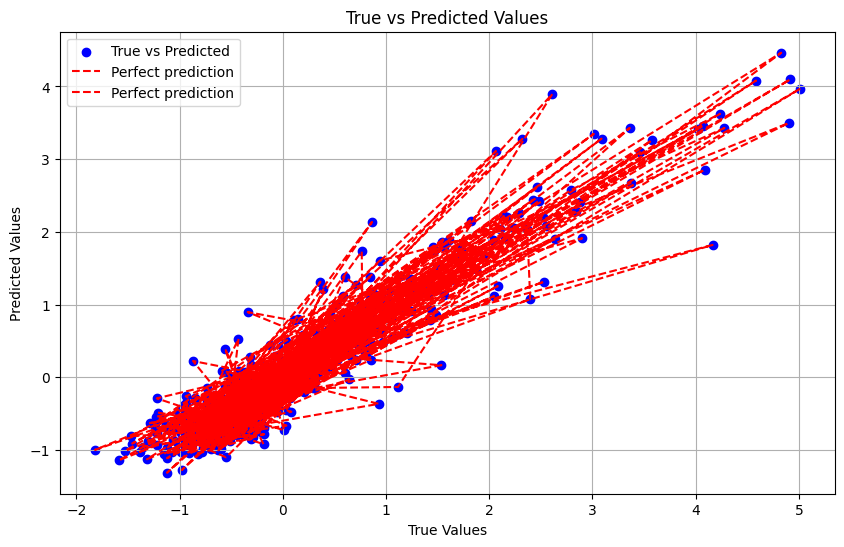

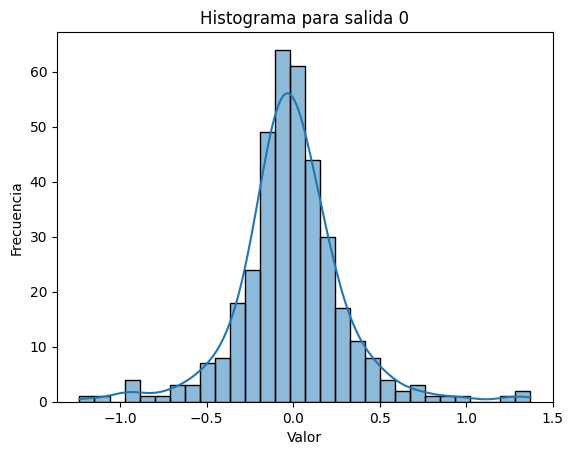

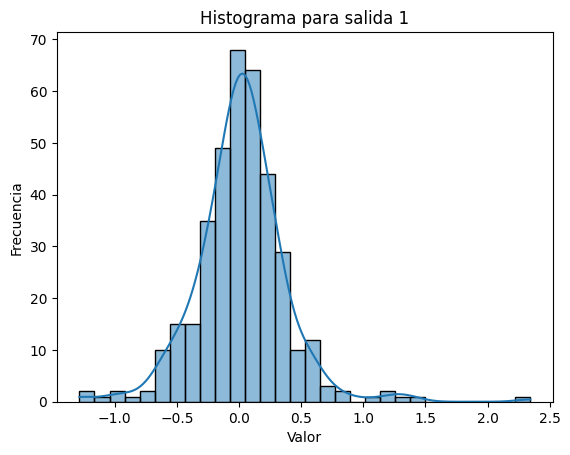

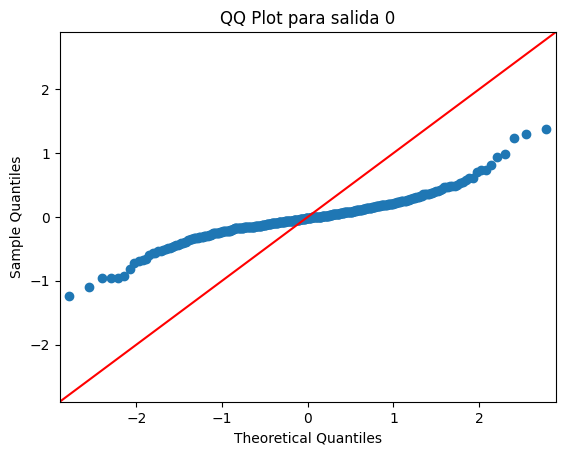

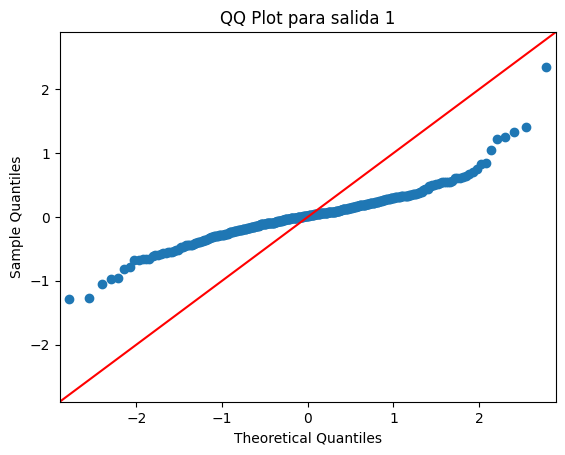

Time:  7.724259614944458


In [15]:
# Levenberg-Maquardt
time_old = time.time()

levenberg = Levenberg_Maquardt(np.array(X_gas_turbine), np.array(y_gas_turbine), degree=2, tolerance=50)
levenberg.train(verbose=True)
levenberg.test()
levenberg.plot(metrics=True)
time_new = time.time()
print("Time: ", time_new - time_old)